In [4]:
import jieba
import re
import numpy as np
import pprint

ignore_words = {'的', '地', '了', '和', '是', '就', '都', '而', '及', '与', '着', '或',
              '一个', '没有', '我', '我们', '你', '你们', '他', '他们', '她', '她们', '它', '他们', '们', '是否'}

In [20]:
filtrate = re.compile('[^\u4E00-\u9FA5]')#中文字,字母
filtrate_sentence = re.compile('[^\u4E00-\u9FA5。！？．]')#中文字,字母,句子结束标点

def splitStrToWordLists(s, wordLists):
    sentences = re.split("。|！|？|．", s)
    for sentence in sentences:
        wordList = [word for word in jieba.lcut(sentence) 
                    if word != ' ' and word not in ignore_words]
        if len(wordList) > 0:
            wordLists.append(wordList)

In [21]:
wordLists = []

for i in range(1, 16):
    file = open('doc/%d_jian.txt' % i, 'r')
    for line in file.readlines():
        splitStrToWordLists(line, wordLists)
    file.close()
    
len(wordLists)

221092

In [7]:
from gensim.models import word2vec
model = word2vec.Word2Vec(wordLists, min_count=1, size=50)
model.save('tonghua15_50.model')

In [27]:
pprint.pprint(model.most_similar(['西瓜']))
print(model.similarity('国王', '公主'))
print(model.similarity('公鸡', '公主'))
pprint.pprint(model.wv.most_similar_cosmul(positive=['本领'], negative=['公主']))

[('梨', 0.9455959796905518),
 ('葫芦', 0.9290562272071838),
 ('桃子', 0.9210245013237),
 ('小狗', 0.9198269248008728),
 ('蛋糕', 0.9195259809494019),
 ('糖', 0.9190055131912231),
 ('裤子', 0.918423056602478),
 ('草料', 0.9183000326156616),
 ('胡萝卜', 0.9181028008460999),
 ('田园', 0.9126637578010559)]
0.841088425094
0.488630271972
[('学一', 2.2465381622314453),
 ('原出', 2.227276563644409),
 ('见异思迁', 2.222698926925659),
 ('有何见教', 2.0982673168182373),
 ('七元', 2.0765037536621094),
 ('查遍', 2.0610101222991943),
 ('油腻', 2.0552165508270264),
 ('比咪', 2.0378568172454834),
 ('可免', 2.034574270248413),
 ('父子天性', 2.0330138206481934)]


In [30]:
import MySQLdb
import json

db = MySQLdb.connect("slugchat-test.lorabit.com", "root", "password", "slugchat")
cursor = db.cursor()

ignore_words = {'的', '地', '了', '和', '是', '就', '都', '而', '及', '与', '着', '或',
              '一个', '没有', '我', '我们', '你', '你们', '他', '他们', '她', '她们', '它', '他们', '们', '是否'}

playlists = {}
with open('view_lists_finial.txt', 'r') as data_file:
    playlists = json.load(data_file)

fre_story = {}
for playlist in playlists:
    for sid in playlists[playlist]['list']:
        if sid in fre_story:
            fre_story[sid] += + 1
        else:
            fre_story[sid] = 1
            
sql = "SELECT storyId, entityName, content FROM slugchat.tbl_stories"
cursor.execute(sql)
results = cursor.fetchall()

filtrate = re.compile('[^\u4E00-\u9FA5]')#中文字,字母
word_freq = {}

for story in results:
    if story[0] in fre_story:
        content = filtrate.sub(r' ', story[2])
        for word in jieba.lcut(content):
            if word != ' ' and word not in ignore_words:
                if word in word_freq:
                    word_freq[word] += 1
                else:
                    word_freq[word] = 1

freq_word = []
for word, freq in word_freq.items():
    freq_word.append((word, freq))
freq_word.sort(key = lambda x: x[1], reverse = True)

print('--- freq word ---')
print(freq_word[:30])

--- freq word ---
[('小', 126), ('说', 120), ('在', 118), ('妈妈', 112), ('把', 96), ('又', 84), ('去', 80), ('到', 67), ('大', 65), ('来', 64), ('有', 61), ('呀', 56), ('里', 55), ('很', 52), ('也', 52), ('上', 50), ('西瓜', 44), ('吃', 42), ('自己', 40), ('吧', 39), ('想', 36), ('不', 36), ('走', 36), ('青蛙', 36), ('得', 35), ('跑', 34), ('狼', 34), ('苹果', 34), ('好', 33), ('可是', 31)]


In [83]:
# -*- coding: utf-8 -*-
import matplotlib.pyplot as plt
import matplotlib
from sklearn.manifold import TSNE
zhfont1 = matplotlib.font_manager.FontProperties(fname='/usr/share/fonts/MyFonts/simsun.ttc')


def visulalizeWord2Vec(model, words, flg_name):
    visualizeVecs = []
    visualizeWords = []
    for word in words:
        visualizeVecs.append(model[word])
        visualizeWords.append(word)
    visualizeVecs = np.array(visualizeVecs).astype(np.float64)
    
    Y = TSNE(n_components=2,learning_rate=10).fit_transform(visualizeVecs)
    
    
    plt.figure(figsize=(20,15))
#     plt.figure(figsize=(20,30))
    
#     plt.subplot(2, 1, 1)
    for i in range(len(visualizeWords)):
        color = 'red'
        plt.text(Y[i, 0], Y[i, 1], visualizeWords[i],
                 bbox=dict(facecolor=color, alpha=0.1),
                 fontproperties=zhfont1)
    plt.xlim((np.min(Y[:, 0]), np.max(Y[:, 0])))
    plt.ylim((np.min(Y[:, 1]), np.max(Y[:, 1])))

#     plt.subplot(2, 1, 2)
#     temp = (visualizeVecs - np.mean(visualizeVecs, axis=0))
#     covariance = 1.0 / visualizeVecs.shape[0] * temp.T.dot(temp)
#     U, S, V = np.linalg.svd(covariance)
#     coord = temp.dot(U[:, 0:2])
#     for i in range(len(visualizeWords)):
# # #         print(i)
# # #         print(coord[i, 0])
# # #         print(coord[i, 1])
#         color = 'red'
#         plt.text(coord[i, 0], coord[i, 1], visualizeWords[i],
#                  bbox=dict(facecolor=color, alpha=0.1),
#                  fontproperties=zhfont1)  # fontproperties = ChineseFont1
#     plt.xlim((np.min(coord[:, 0])-5, np.max(coord[:, 0])+5))
#     plt.ylim((np.min(coord[:, 1])-5, np.max(coord[:, 1])+5))
    plt.savefig(flg_name)
    plt.show()

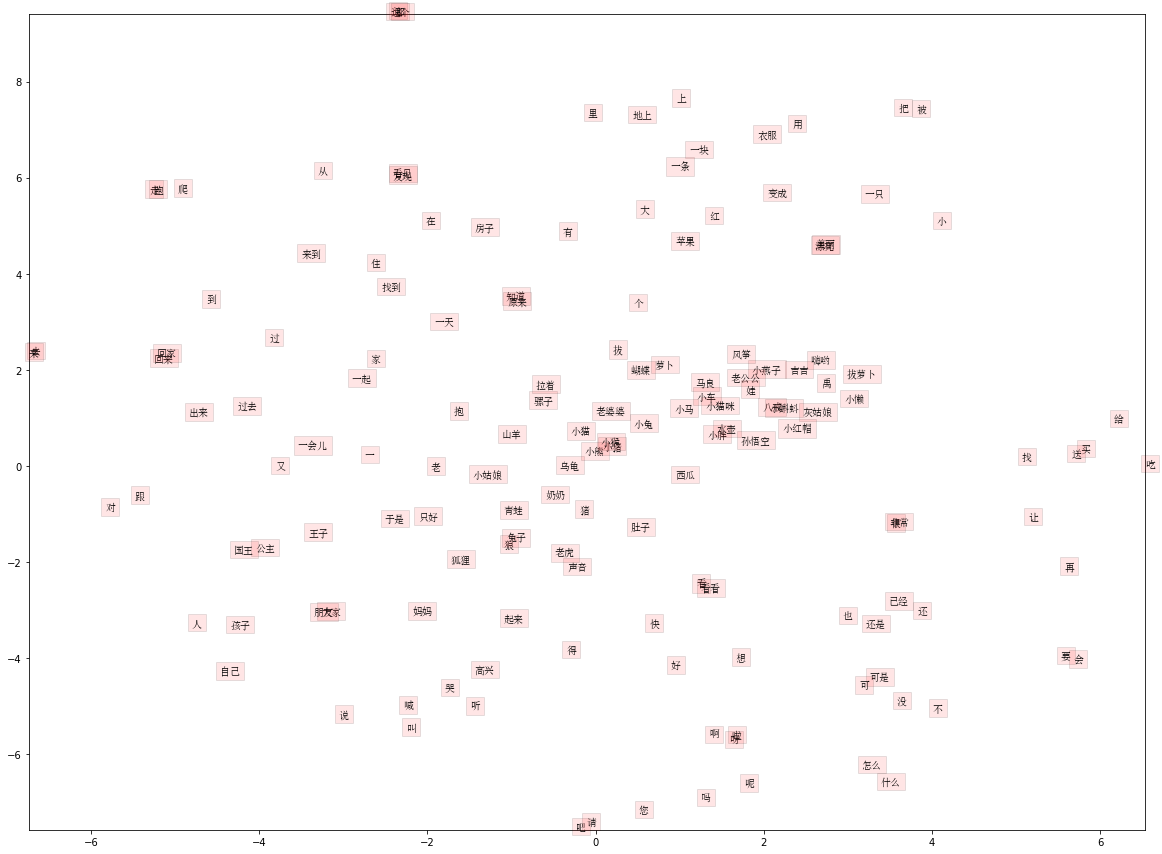

In [84]:
words = []
for i in range(0, 150):
    words.append(freq_word[i][0])
model = word2vec.Word2Vec.load('tonghua15_50.model')
visulalizeWord2Vec(model, words, 'tonghua15_50')

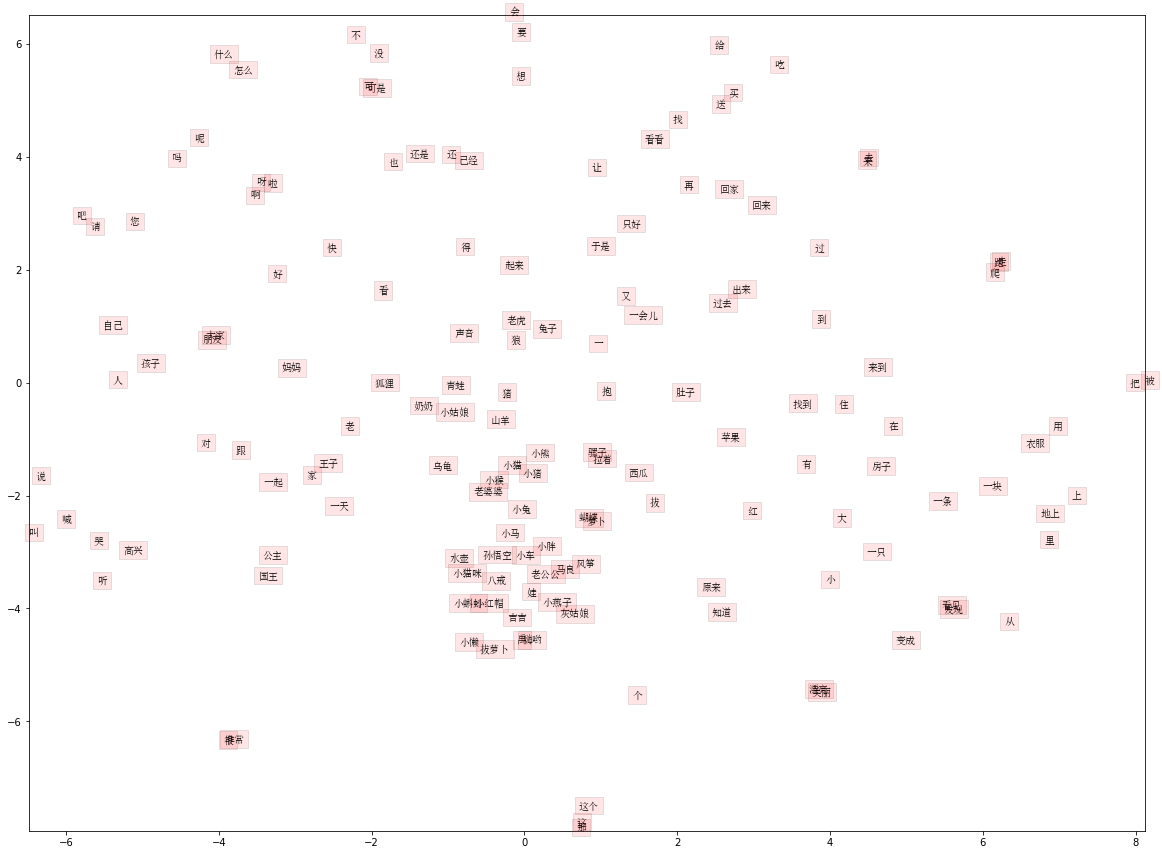

In [ ]:
model = word2vec.Word2Vec(wordLists, min_count=1, size=100)
model.save('tonghua15_100.model')
visulalizeWord2Vec(model, words, 'tonghua15_100')

In [ ]:
model = word2vec.Word2Vec(wordLists, min_count=1, size=25)
model.save('tonghua15_25.model')
visulalizeWord2Vec(model, words, 'tonghua15_25')